In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional, RepeatVector, TimeDistributed, ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
import time

In [2]:
df = pd.read_csv('../datasets/Plasma current.csv',usecols=[1]).clip(0)

In [3]:
df.head()

,Plasma_current
0,0.0000
1,1.3591
2,5.7585
3,11.6940
4,17.8730


In [4]:
df.size

401000

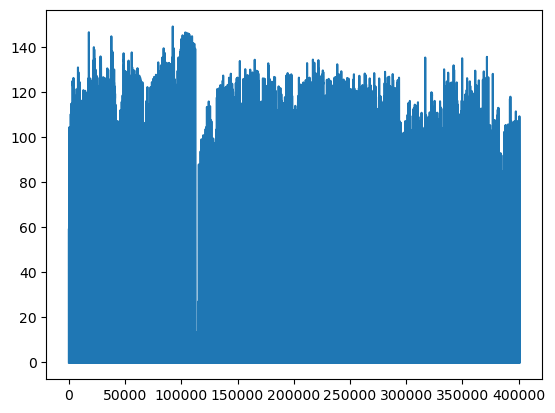

In [5]:
plt.plot(df)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
dataset = scaler.fit_transform(df)

In [7]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
test.shape

(80200, 1)

In [8]:
def to_sequences(dataset, time_window,output):
    x = []
    y = []

    for i in range(len(dataset)-time_window-1-output):
        #print(i)
        window = dataset[i:(i+time_window), 0]
        x.append(window)
        y.append(dataset[i+time_window:i+time_window+output, 0])

    return np.array(x),np.array(y)

In [9]:
time_window = 10
output=20 # Number of time steps to look back
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, time_window, output)
testX, testY = to_sequences(test, time_window,output)

In [10]:
trainY.shape

(320769, 20)

In [11]:
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
print(trainX.shape)
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))
print(testX.shape)
trainY = trainY.reshape((trainY.shape[0], trainY.shape[1], 1))
print(trainY.shape)
testY= testY.reshape((testY.shape[0], testY.shape[1], 1))
print(testY.shape)

(320769, 10, 1)
(80169, 10, 1)
(320769, 20, 1)
(80169, 20, 1)


In [12]:
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model

In [13]:
model = Sequential()

input_layer = Input(shape=(10,1))
x = Bidirectional(LSTM(50, activation='elu'))(input_layer)
x = RepeatVector(output)(x)
x = LSTM(100, activation='elu', return_sequences=True)(x)
x = TimeDistributed(Dense(1,activation='elu'))(x)

model = Model(inputs=input_layer, outputs=x)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 20, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 20, 100)             │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 20, 1)               │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 101,301 (395.71 KB)

 Trainable params: 101,301 (395.71 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss='mse', optimizer='adam')

In [15]:
# callback = [keras.callbacks.EarlyStopping(monitor='loss',patience=3)]

In [16]:
model.fit(trainX, trainY, epochs=20, batch_size=32,validation_data=(testX,testY))

Epoch 1/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 302s 28ms/step - loss: 0.0094 - val_loss: 0.0058
Epoch 2/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 278s 28ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 3/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 280s 28ms/step - loss: 0.0065 - val_loss: 0.0058
Epoch 4/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 283s 28ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 5/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 292s 29ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 6/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 293s 29ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 7/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 297s 30ms/step - loss: 0.0064 - val_loss: 0.0054
Epoch 8/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 295s 29ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 9/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 303s 30ms/step - loss: 0.0063 - val_loss: 0.0056
Epoch 10/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 266s 27ms/step - loss: 0.0063 - val_loss: 0.0053
Epoch 11/20
10025/10025 ━━━━━━━━━━━━━━━━━━━━ 270s 27ms/step - loss: 0

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

10025/10025 ━━━━━━━━━━━━━━━━━━━━ 118s 11ms/step
2506/2506 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step


In [18]:
trainPredict.shape

(320769, 20, 1)

In [19]:
trainY.shape

(320769, 20, 1)

In [20]:
trainPredict = trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[1])
testPredict = testPredict.reshape(testPredict.shape[0],testPredict.shape[1])

In [21]:
trainY = trainY.reshape(trainY.shape[0],trainY.shape[1])
testY = testY.reshape(testY.shape[0],testY.shape[1])

In [22]:
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)
trainY = scaler.inverse_transform(trainY)
testY = scaler.inverse_transform(testY)

In [23]:
from sklearn.metrics import mean_squared_error as mse
import math

In [24]:
train_RMSE = math.sqrt(mse(trainPredict,trainY))
test_RMSE = math.sqrt(mse(testPredict,testY))

In [25]:
train_RMSE

11.702799579973034

In [26]:
test_RMSE

11.008175209314754

In [27]:
trainY[:2]

array([[35.73 , 40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462,
        55.672, 54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567,
        53.829, 55.543, 54.524, 56.077],
       [40.792, 42.312, 46.647, 49.429, 52.68 , 56.724, 55.462, 55.672,
        54.54 , 52.421, 51.208, 50.691, 51.483, 52.988, 52.567, 53.829,
        55.543, 54.524, 56.077, 57.71 ]])

In [28]:
trainPredict[:2]

array([[34.271156, 37.12929 , 40.77268 , 42.532112, 43.947697, 46.007683,
        48.253   , 50.435173, 52.712204, 55.097927, 57.524136, 59.90118 ,
        62.143383, 64.18554 , 65.996185, 67.570786, 68.92428 , 70.08344 ,
        71.080475, 71.948135],
       [40.891624, 43.988956, 49.614323, 52.063927, 54.485584, 57.526432,
        60.46613 , 63.05873 , 65.54794 , 68.000175, 70.38155 , 72.67929 ,
        74.88236 , 76.97195 , 78.92997 , 80.73096 , 82.3557  , 83.78847 ,
        85.02022 , 86.04963 ]], dtype=float32)

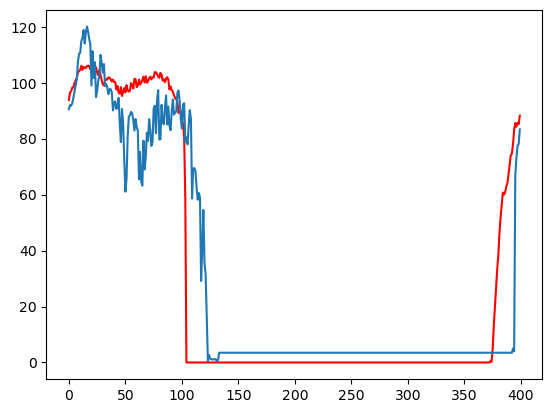

In [29]:
plt.plot(testY[400:800,19],color='r')
plt.plot(testPredict[400:800,19])

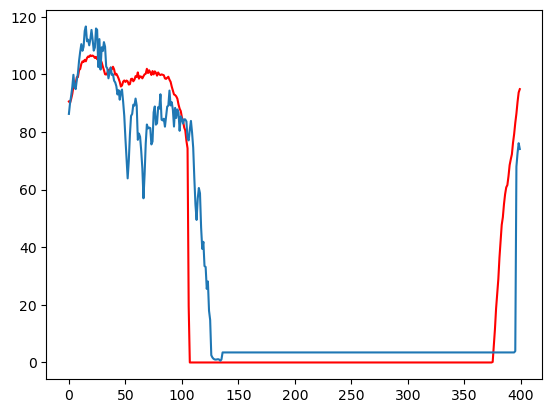

In [30]:
plt.plot(testY[800:1200,19],color='r')
plt.plot(testPredict[800:1200,19])

In [31]:
TestData = pd.read_csv("../datasets/test_10-20.csv",index_col = 0)
TestData = TestData.values

In [32]:
n_steps_in, n_steps_out = 10,20
n_features = 1

In [33]:
x_test = TestData[:,0:n_steps_in]
y_test = TestData[:,n_steps_in : n_steps_in+n_steps_out]

In [34]:
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
# print(x_train.shape)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
print(x_test.shape)
# y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
# print(y_train.shape)
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
print(y_test.shape)

(8134, 10, 1)
(8134, 20, 1)


In [35]:
y_predicttest = model.predict(x_test)

255/255 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


In [37]:
y_predicttest =  y_predicttest.reshape(y_predicttest.shape[0],y_predicttest.shape[1])
y_test =  y_test.reshape(y_test.shape[0],y_test.shape[1])

In [38]:
math.sqrt(mse(y_predicttest,y_test))

0.09189207648204496

In [39]:
def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

In [40]:
# train_acc=np.zeros(Num_Exp)
test_acc=np.zeros(1)
Step_RMSE=np.zeros([1,n_steps_out])

In [41]:
test_acc[0] = rmse( y_predicttest, y_test)

In [42]:
test_acc[0]

0.4109538592149246

In [43]:
Best_RMSE=test_acc[0]
Best_Predict_Test=y_predicttest

In [44]:
for j in range(n_steps_out):
    Step_RMSE[0][j]=rmse(y_predicttest[:,j], y_test[:,j])

In [45]:
Step_RMSE

array([[0.02301836, 0.03168423, 0.03886966, 0.03989255, 0.04347069,
        0.04914011, 0.0569842 , 0.06477039, 0.07111334, 0.07883754,
        0.08747765, 0.09546662, 0.10273178, 0.1095505 , 0.11618856,
        0.12243327, 0.12840658, 0.1337773 , 0.13790787, 0.14146916]])

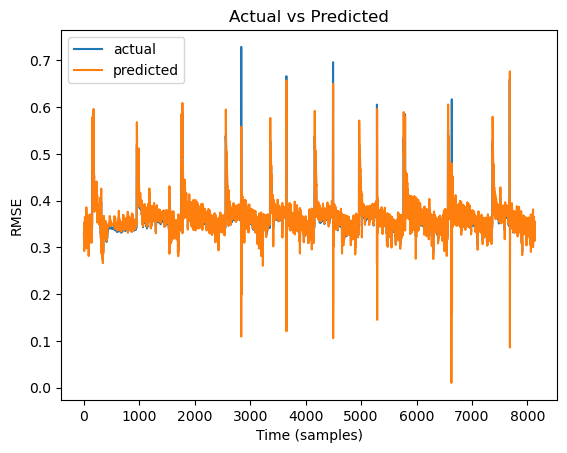

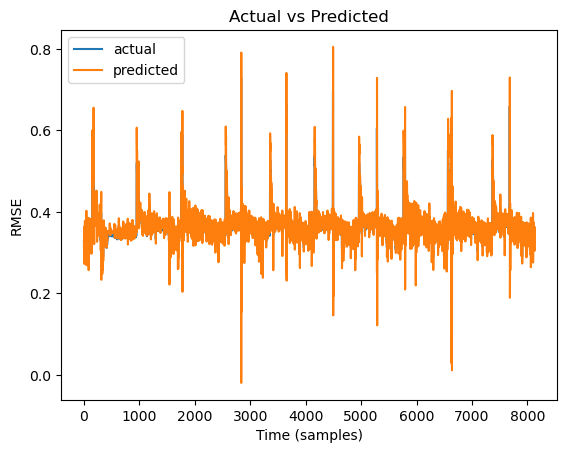

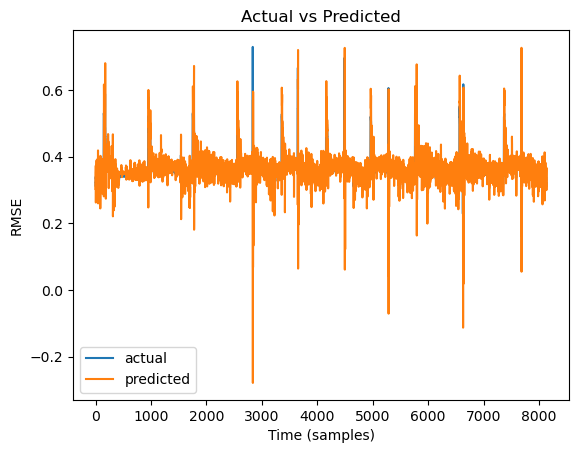

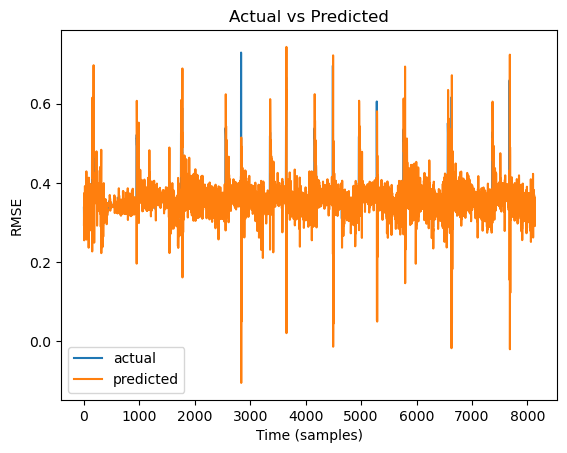

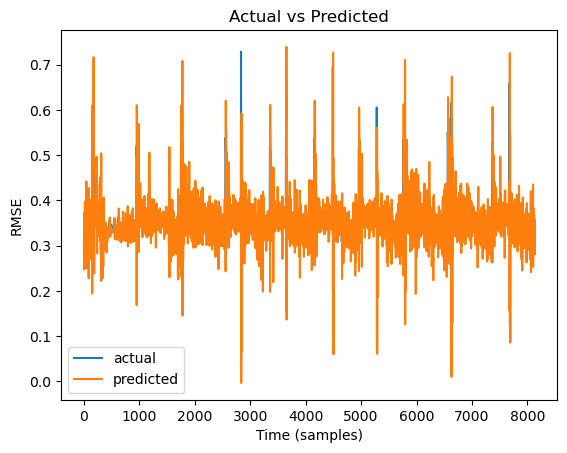

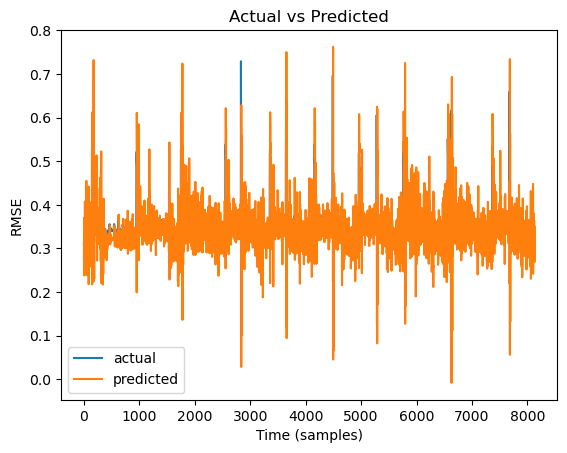

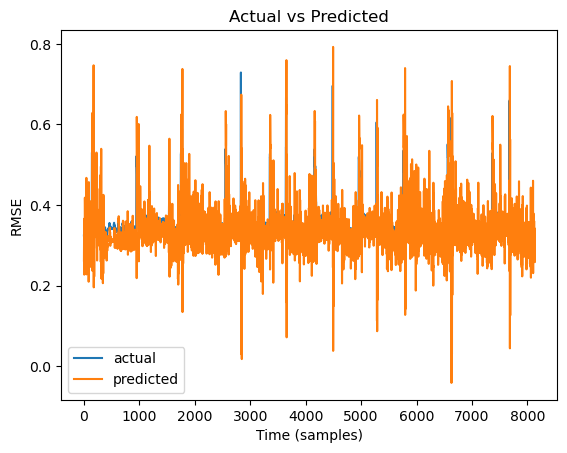

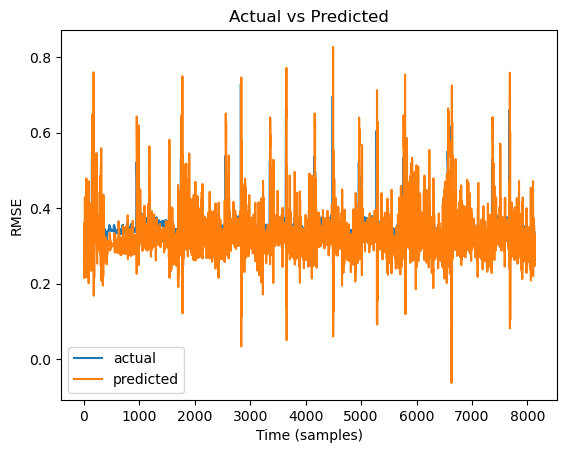

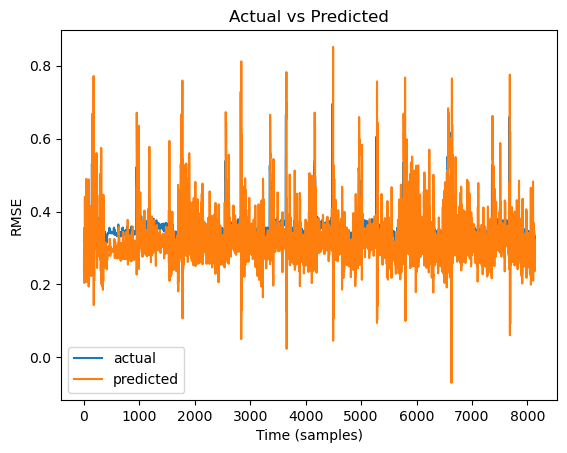

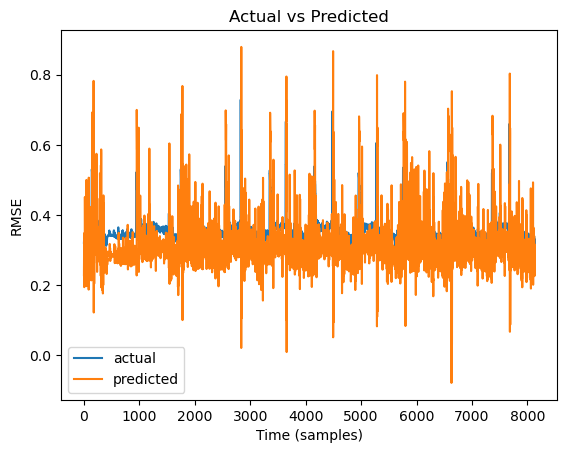

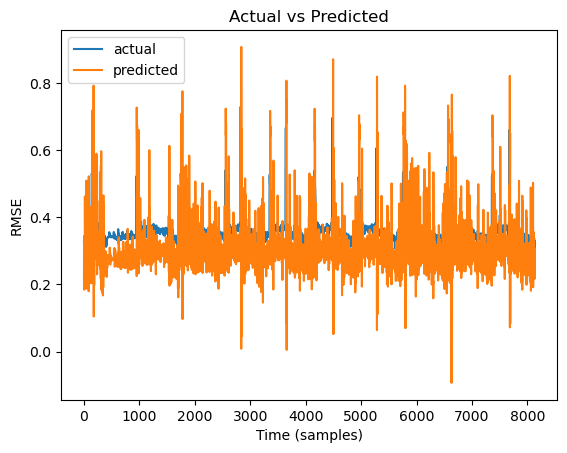

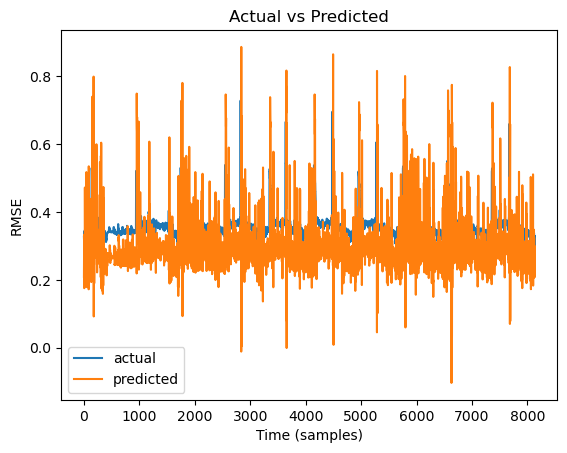

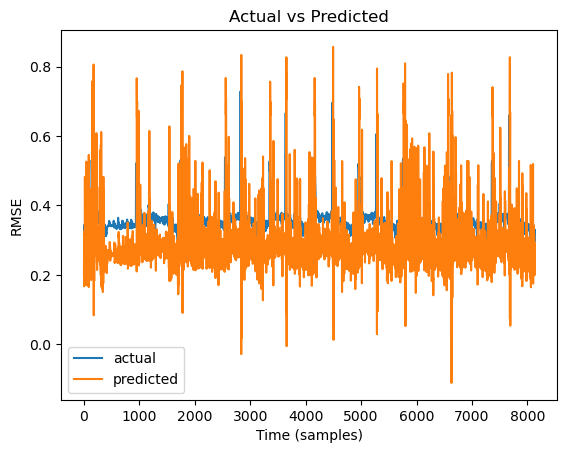

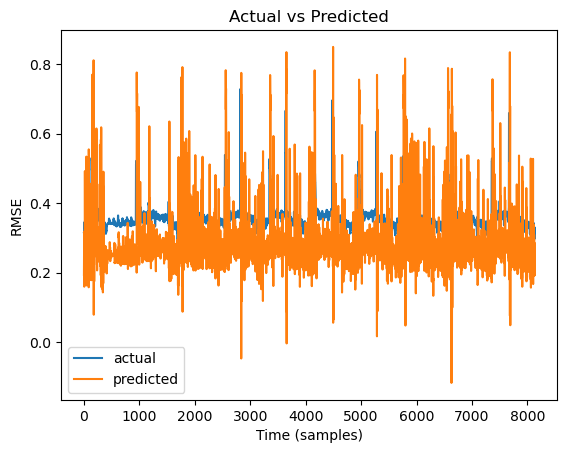

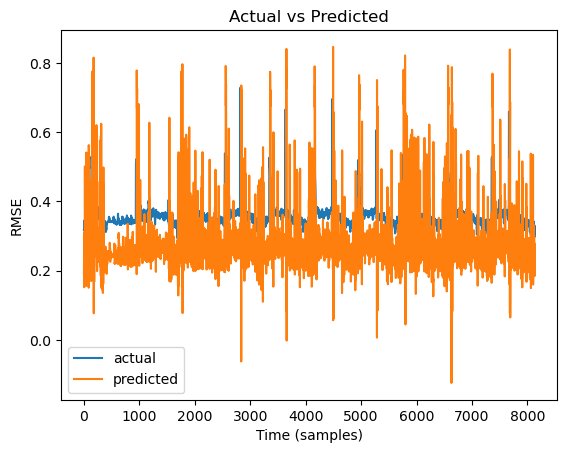

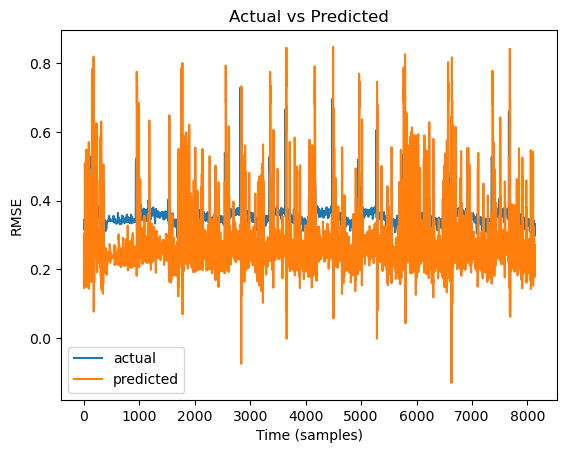

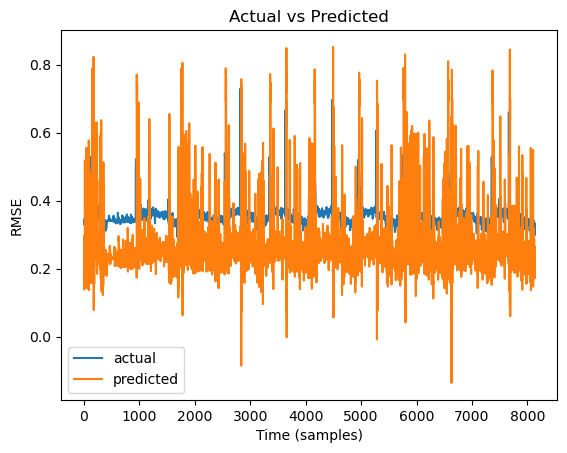

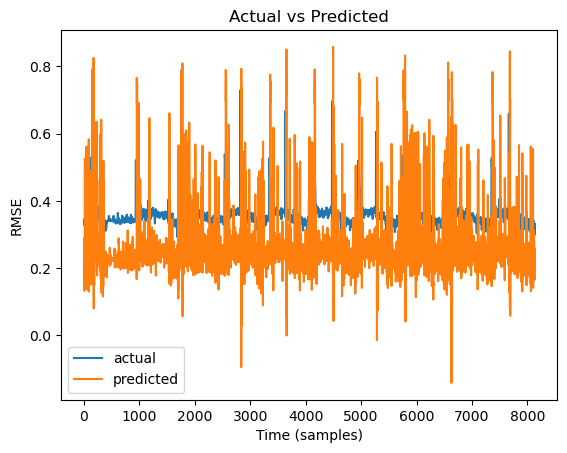

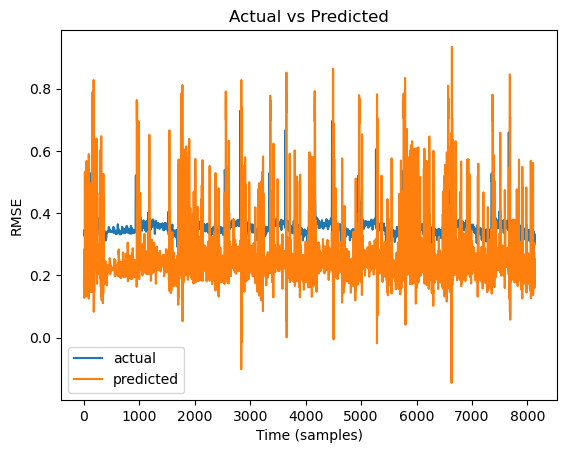

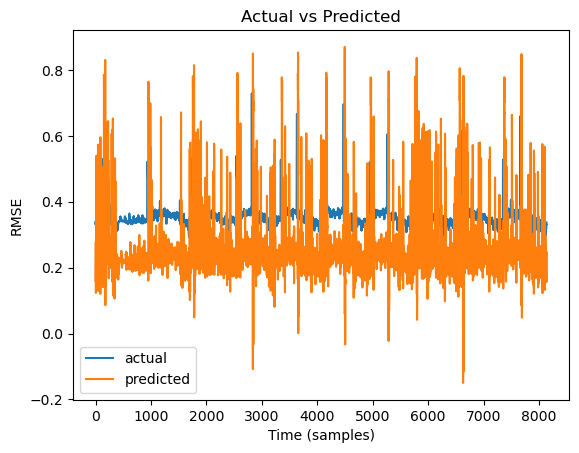

In [46]:
x_data=np.linspace(0,y_test.shape[0], num=y_test.shape[0])
for j in range(n_steps_out):
    plt.figure()
    plt.plot(x_data, y_test[:,j], label='actual')
    plt.plot(x_data, Best_Predict_Test[:,j], label='predicted')
    plt.ylabel('RMSE')
    plt.xlabel('Time (samples)')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()
    plt.close()

In [57]:
from keras.models import load_model

model.save('model.h5')

ValueError: Unable to synchronously create dataset (name already exists)